In [1]:
%autoreload 2
%load_ext autoreload

UsageError: Line magic function `%autoreload` not found.


In [117]:
from typing import List
import torch 
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd 
import seaborn as sns 
import torch.nn.functional as F


def show(tensors: List[torch.Tensor]):
    if not isinstance(tensors, list):
        tensors = [tensors]
    fig, axs = plt.subplots(1, len(tensors), figsize=(5 * len(tensors), 5))

    for i, x in enumerate(tensors):
        sns.heatmap(
            x.numpy(), 
            cmap='rocket_r', 
            cbar=True,
            linewidths=.5,
            ax=axs[i] if len(tensors) > 1 else axs
        )

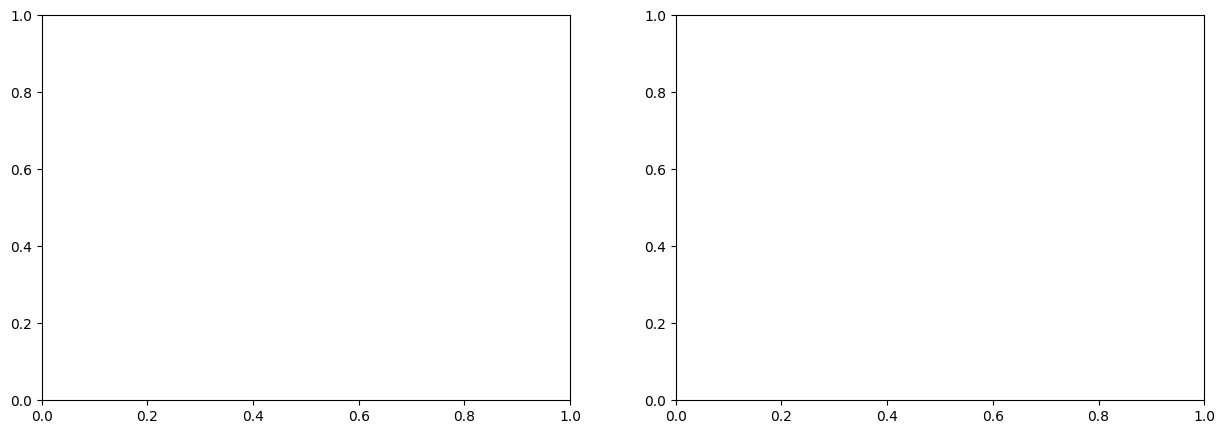

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


In [119]:
axs[0]

<Axes: >

In [128]:
class Model(nn.Module):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, d_model, bias=True)
        self.activation = activation
    
    def forward(self, x):
        x = self.embeddings(x)
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        y = self.embeddings.weight @ x.T
        return y, {}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y)
        return loss, output, meta
        
def learn_mapping(
    num_kv_pairs: int = 16, 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    device: int = 0, 
    model_cls: type = Model,
    **kwargs
):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)

    model = model_cls(num_kv_pairs=num_kv_pairs, d_model=d_model, **kwargs)
    model.to(device)

    # Define a loss function and an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        loss, output, meta = model.loss(keys, values)    # Forward pass
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if epoch % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
                'accuracy': (output.argmax(dim=1) == values).float().mean().item()
            })
    return metrics[-1], metrics, meta, model, {k: v for k, v in zip(keys, values)}

In [129]:
metrics, _, _, model, kv = learn_mapping(
    num_kv_pairs=5, 
    d_model=5, 
    pbar=True, 
    num_epochs=6_000,
    log_interval=200,
    device="cpu", 
    model_cls=Model,
    freeze_embeddings=True
)
metrics

  0%|          | 0/6000 [00:00<?, ?it/s]

{'epoch': 5800, 'loss': 0.00018520557205192745, 'accuracy': 1.0}

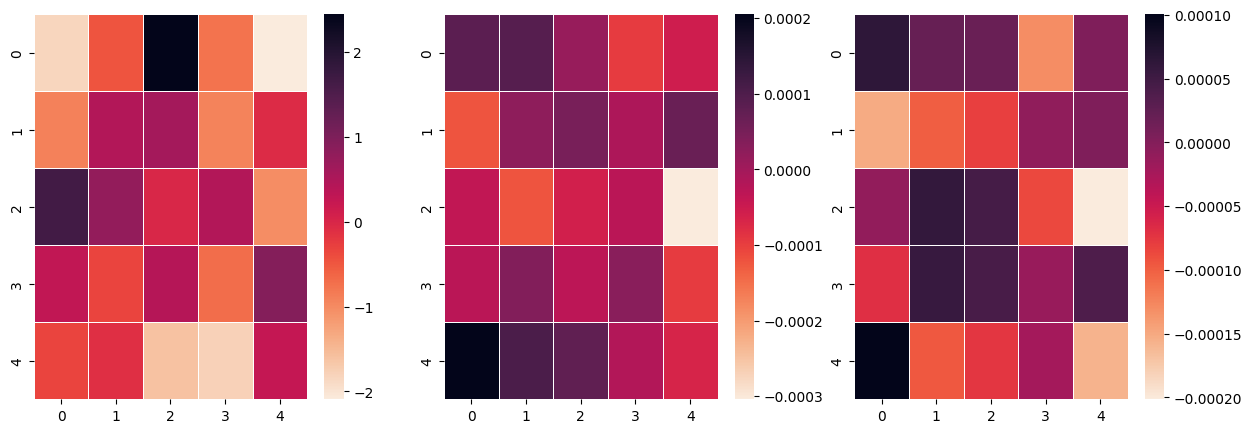

In [130]:
embs = model.embeddings.weight.detach()
w1 = model.layer1.weight.grad.detach()
w2 = model.layer2.weight.grad.detach()
show([embs, w1.T, w2])

# L1 Regularization

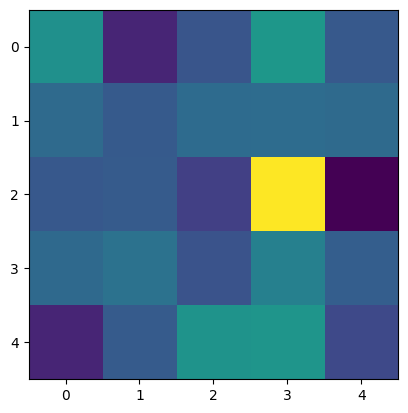

In [62]:
class ModelL1(nn.Module):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, d_model, bias=True)
        self.activation = activation
    
    def forward(self, x):
        x = self.embeddings(x)
        x = self.activation(self.layer1(x))
        meta = {"act": x}
        x = self.layer2(x)
        y = self.embeddings.weight @ x.T
        return y, meta

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y) + torch.norm(meta["act"], p=1)
        return loss, output, meta
        
        

In [46]:
## 

{tensor(4): tensor(0),
 tensor(1): tensor(3),
 tensor(3): tensor(4),
 tensor(2): tensor(2),
 tensor(0): tensor(1)}

In [ ]:
# procrustes 

# can it relearn the spherical code (expressly normalize as units)
# minimum angle between vectors -- look at the chart
# minimum angle of the code -- look 

# given code, does it learn the mapping, fix the k
# can i learn the code, fix the v
# vary both D
# insist that that the k 


# connection between spherical codes and the gram matrix 
# diagnostic of looking at the gram matrix
# understanding finite codes 
# developing a test for whether or not a code is being used (this part of the )
# can we extract the code basis (so we can see what the v's are)

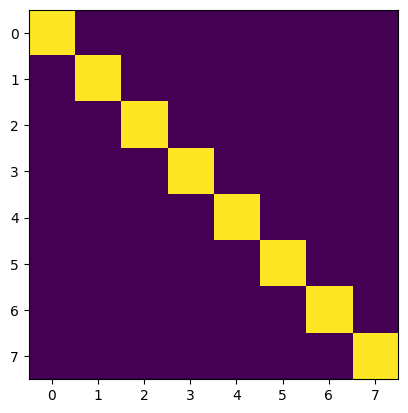

In [23]:
plt.imshow(x)

In [ ]:
model.

In [62]:
x = torch.tensor([12], device=0)
y = torch.tensor([14], device=0)

y_pred, _ = model(x)

loss = nn.CrossEntropyLoss()(y_pred, y)

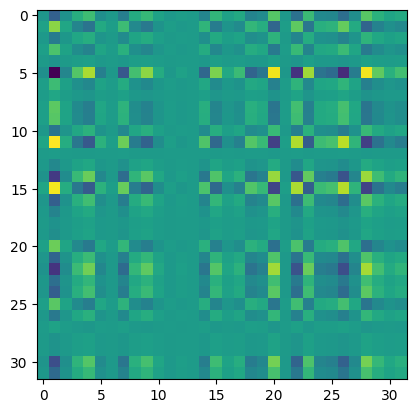

In [63]:
plt.imshow(model.layer.weight.grad.detach().cpu())

In [49]:
loss.backward()

In [25]:
y.shape

torch.Size([1])

In [27]:
y_pred, _ = model(x)

loss = nn.CrossEntropyLoss()(y_pred, y)

ValueError: Expected input batch_size (16) to match target batch_size (1).

In [28]:
y_pred.shape

torch.Size([16, 1])

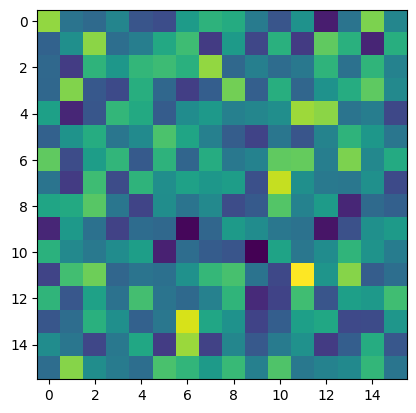

In [13]:
plt.imshow(model.layer.weight.detach().cpu())

In [4]:
class MOELayer(nn.Module):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        num_experts: int = 16, 
        top_k: int = 4,
        freeze_embeddings: bool = True
    ):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        self.layer1 = nn.Linear(d_model, num_experts, bias=True)
        self.experts = nn.Linear(d_model, d_model * num_experts, bias=True)
    
    def forward(self, x):
        x = self.embeddings(x)
        a = self.layer1(x)
        # zero out scores for non-top_k experts
        scores = torch.softmax(a, dim=1)
    
        # Get top-k scores and their indices
        _, top_k_indices = scores.topk(self.top_k, dim=1)
        
        # Create a mask where only the top-k indices are set to True
        mask = torch.zeros_like(scores).scatter_(1, top_k_indices, 1).bool()
        
        # Zero out all scores not in the top-k
        scores = scores.masked_fill(~mask, 0)
    
        x = self.experts(x)
        x = x.reshape(x.shape[0], x.shape[1] // self.num_experts, self.num_experts)
        x = (scores.unsqueeze(dim=1) * x).sum(dim=-1)

        y = self.embeddings.weight @ x.T
        return y, {"scores": scores}

In [5]:
metrics, df, _ = learn_mapping(num_kv_pairs=512, d_model=32, pbar=True, num_epochs=1_000, device=3)
metrics 

100%|██████████| 1000/1000 [00:00<00:00, 1549.37it/s]


{'epoch': 800, 'loss': 2.6415061950683594, 'accuracy': 0.439453125}

In [6]:
metrics, df, meta = learn_mapping(num_kv_pairs=512, d_model=32, pbar=True, num_epochs=1_000, device=3, layer_cls=MOELayer, num_experts=16, top_k=1) 
metrics

100%|██████████| 1000/1000 [00:00<00:00, 1202.98it/s]


{'epoch': 800, 'loss': 0.20947353541851044, 'accuracy': 0.98828125}

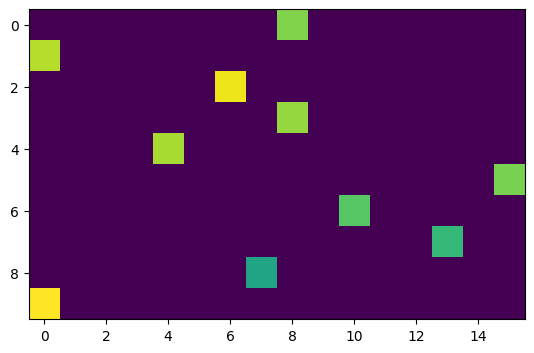

In [7]:
plt.imshow(meta["scores"].detach().cpu()[:10])

In [8]:
(meta["scores"] > 0).sum(dim=0)

tensor([63,  9, 36,  7, 62, 35, 31, 26, 34, 15, 39, 41,  2, 22, 40, 50],
       device='cuda:3')

In [12]:
num_kv_pairs = 16

# num_kv_pairs_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
# num_kv_pairs_list = [131072]
num_kv_pairs_list = [128, 256, 512, 1024, 2048, 4096, 8192]

d_model_list = [16, 32, 64, 128, 256]
# d_model_list = [16, 32, 64, 128]
results = []

for moe in [True, False]:
    for num_kv_pairs in tqdm(num_kv_pairs_list, desc='num_kv_pairs loop', position=0):
        for d_model in tqdm(d_model_list, desc='d_model loop', position=1, leave=False):
            kwargs = {} if not moe else {'layer_cls': MOELayer, 'num_experts': d_model, "top_k": 1}
            metrics, _, _ = learn_mapping(
                num_kv_pairs=num_kv_pairs, 
                d_model=d_model, 
                num_epochs=4_000,
                device=6,
                **kwargs
            )
            results.append(
                {
                    'num_kv_pairs': num_kv_pairs,
                    'd_model': d_model,
                    'moe': moe,
                    **metrics
                }
            )


num_kv_pairs loop: 100%|██████████| 7/7 [02:24<00:00, 20.63s/it]


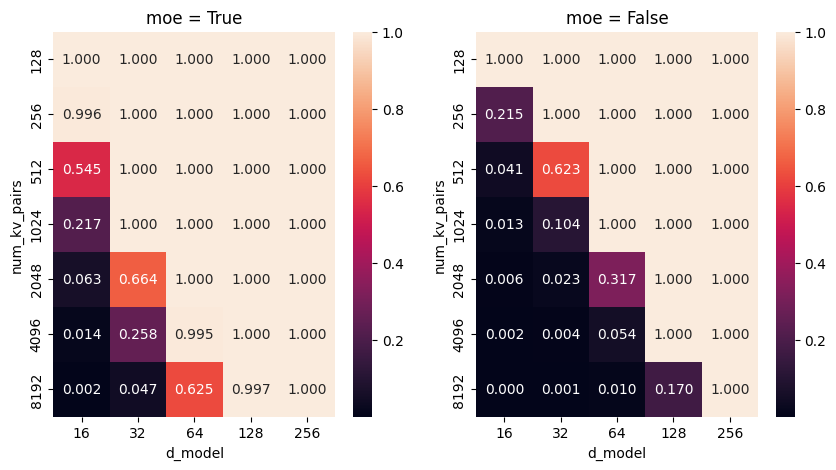

: 

In [13]:
# Pivot the data
df = pd.DataFrame(results)
ig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed

for i, moe in enumerate([True, False]):  # Assuming you want to create heatmaps for both True and False
    pivot_df = df[df["moe"] == moe].pivot(index='num_kv_pairs', columns='d_model', values='accuracy')
    
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f", ax=axs[i])
    axs[i].set_title(f'moe = {moe}')

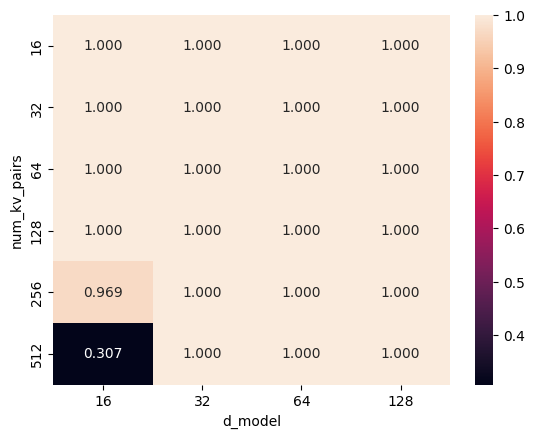

In [28]:
# Pivot the data
df = pd.DataFrame(results)
for moe in [False]:
    pivot_df = df[df["moe"]].pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f")


<Axes: xlabel='d_model', ylabel='num_kv_pairs'>

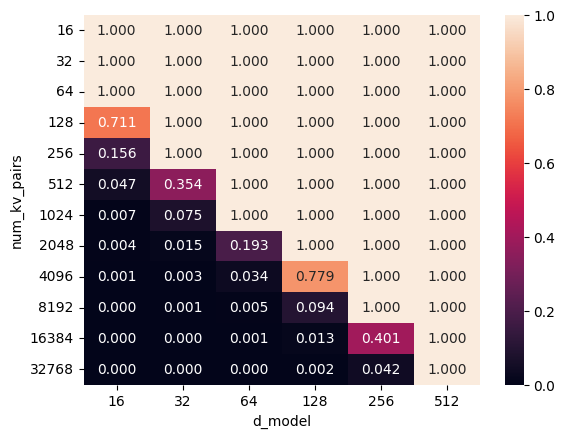

In [69]:
# Pivot the data
df = pd.DataFrame(results)
pivot_df = df.pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


In [70]:
((pivot_df > 0.98).values * pivot_df.index.values[:, None]).max(axis=0) / pivot_df.columns

Float64Index([4.0, 8.0, 16.0, 16.0, 32.0, 64.0], dtype='float64', name='d_model')

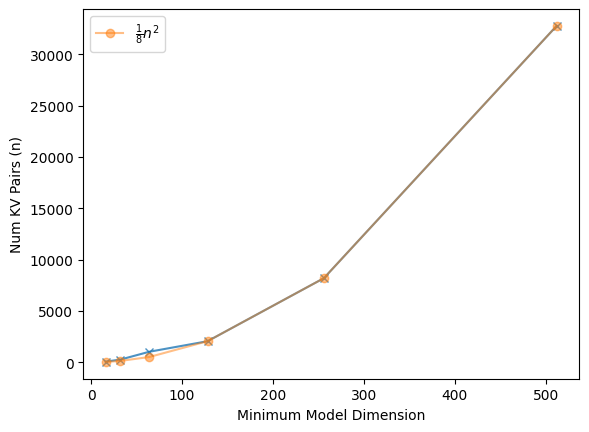

: 

In [78]:
import matplotlib.pyplot as plt
plt.plot(
    pivot_df.columns,
    ((pivot_df > 0.98).values * pivot_df.index.values[:, None]).max(axis=0), 
    marker='x',
    alpha=0.8
)
plt.plot(
    pivot_df.columns,
    (pivot_df.columns ** 2) / 8,
    marker='o',
    alpha=0.5,
    label=r"$\frac{1}{8} n^2$"
)
plt.xlabel("Minimum Model Dimension")
plt.ylabel("Num KV Pairs (n)")
plt.legend()

/Users/sabrieyuboglu/opt/miniconda3/envs/zoology/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


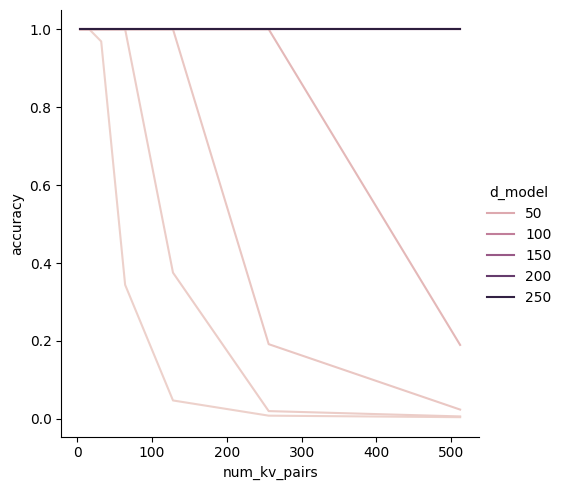

In [87]:
sns.relplot(
    data=df,
    x='num_kv_pairs',
    y='accuracy',
    hue='d_model',
    kind='line'
)

<Axes: >

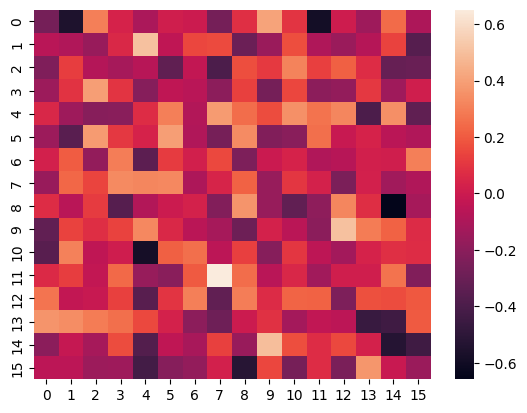

In [63]:

sns.heatmap(layer.layer.weight.detach().numpy())

In [55]:
df = pd.DataFrame(metrics)
df

,epoch,loss,accuracy
0,0,5.130624,0.0625
1,100,0.017283,1.0000
2,200,0.007714,1.0000
3,300,0.004847,1.0000
4,400,0.003494,1.0000
5,500,0.002713,1.0000
6,600,0.002208,1.0000
7,700,0.001856,1.0000
8,800,0.001597,1.0000
9,900,0.001399,1.0000


In [7]:
layer = nn.Linear(16, 16, bias=False)


SyntaxError: invalid syntax (1975303595.py, line 1)